Blah blah blah


Emphasis, aka italics, with *asterisks* or _underscores_.

Strong emphasis, aka bold, with **asterisks** or __underscores__.

Combined emphasis with **asterisks and _underscores_**.

Strikethrough uses two tildes. ~~Scratch this.~~

[I'm an inline-style link](https://www.google.com)

[I'm an inline-style link with title](https://www.google.com "Google's Homepage")

[I'm a reference-style link][Arbitrary case-insensitive reference text]

[I'm a relative reference to a repository file](../blob/master/LICENSE)

[You can use numbers for reference-style link definitions][1]

Or leave it empty and use the [link text itself].

URLs and URLs in angle brackets will automatically get turned into links. 
http://www.example.com or <http://www.example.com> and sometimes 
example.com (but not on Github, for example).

Some text to show that the reference links can follow later.

[arbitrary case-insensitive reference text]: https://www.mozilla.org
[1]: http://slashdot.org
[link text itself]: http://www.reddit.com
Here's our logo (hover to see the title text):

Inline-style: 
![alt text](https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Logo Title Text 1")

Reference-style: 
![alt text][logo]

[logo]: https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Logo Title Text 2"

Inline `code` has `back-ticks around` it.

```javascript
var s = "JavaScript syntax highlighting";
alert(s);
```
 
```python
s = "Python syntax highlighting"
print s
```
 
```
No language indicated, so no syntax highlighting. 
But let's throw in a <b>tag</b>.
```


Colons can be used to align columns.

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
| col 3 is      | right-aligned | $1600 |
| col 2 is      | centered      |   $12 |
| zebra stripes | are neat      |    $1 |

There must be at least 3 dashes separating each header cell.
The outer pipes (|) are optional, and you don't need to make the 
raw Markdown line up prettily. You can also use inline Markdown.

Markdown | Less | Pretty
--- | --- | ---
*Still* | `renders` | **nicely**
1 | 2 | 3

> Blockquotes are very handy in email to emulate reply text.
> This line is part of the same quote.

Quote break.

> This is a very long line that will still be quoted properly when it wraps. Oh boy let's keep writing to make sure this is long enough to actually wrap for everyone. Oh, you can *put* **Markdown** into a blockquote. 


<!-- TEASER_END -->

Let's first initialize the notebook:

In [1]:
from __future__ import division, print_function
import numpy as np
np.set_printoptions(precision=6, suppress=True)
import os
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
phi = (np.sqrt(5)+1)/2
fig_width = 10
figsize = (fig_width, fig_width/phi)
%load_ext autoreload
%autoreload 2


Bad key text.latex.unicode in file /usr/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file /usr/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file /usr/local/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/bl

https://github.com/opencovid19-fr/data

In [2]:
URL, data_cache = 'https://raw.githubusercontent.com/opencovid19-fr/data/master/dist/chiffres-cles.json', '/tmp/covid_fr.json'

In [3]:
import pandas as pd

In [4]:
try:
    df = pd.read_json(data_cache)
    print('loading cache')
except:
    df = pd.read_json(URL)
    print('loading from internet')
    df.to_json(data_cache)


loading cache


In [5]:
df

,date,source,sourceType,nom,code,casConfirmes,hospitalises,deces,donneesRegionales,paysTouches,...,hospitalise,hospitalisesReadaptation,hospitalisesAuxUrgences,hospitalisesConventionnelle,reanimations,capaciteReanimation,decesEhpad,casEhpad,casConfirmesEhpad,casPossiblesEhpad
0,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Charente,DEP-16,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Charente-Maritime,DEP-17,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Corrèze,DEP-19,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Creuse,DEP-23,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Dordogne,DEP-24,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,2020-10-09,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Nouvelle-Aquitaine,REG-75,NaN,386.0,531.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28362,2020-10-09,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Occitanie,REG-76,NaN,556.0,629.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28363,2020-10-09,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Auvergne-Rhône-Alpes,REG-84,NaN,1046.0,2011.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28364,2020-10-09,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Provence-Alpes-Côte d'Azur,REG-93,NaN,833.0,1202.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df['date'] = pd.to_datetime(df['date'])
df 

,date,source,sourceType,nom,code,casConfirmes,hospitalises,deces,donneesRegionales,paysTouches,...,hospitalise,hospitalisesReadaptation,hospitalisesAuxUrgences,hospitalisesConventionnelle,reanimations,capaciteReanimation,decesEhpad,casEhpad,casConfirmesEhpad,casPossiblesEhpad
0,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Charente,DEP-16,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Charente-Maritime,DEP-17,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Corrèze,DEP-19,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Creuse,DEP-23,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-24,"{'nom': 'ARS Nouvelle-Aquitaine', 'url': 'http...",agences-regionales-sante,Dordogne,DEP-24,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28361,2020-10-09,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Nouvelle-Aquitaine,REG-75,NaN,386.0,531.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28362,2020-10-09,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Occitanie,REG-76,NaN,556.0,629.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28363,2020-10-09,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Auvergne-Rhône-Alpes,REG-84,NaN,1046.0,2011.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28364,2020-10-09,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Provence-Alpes-Côte d'Azur,REG-93,NaN,833.0,1202.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df['code'].unique()

array(['DEP-16', 'DEP-17', 'DEP-19', 'DEP-23', 'DEP-24', 'DEP-33',
       'DEP-40', 'DEP-47', 'DEP-64', 'DEP-79', 'DEP-86', 'DEP-87', 'FRA',
       'REG-11', 'REG-75', 'WORLD', 'DEP-34', 'DEP-74', 'REG-84',
       'REG-27', 'DEP-02', 'DEP-25', 'DEP-59', 'DEP-60', 'DEP-62',
       'DEP-80', 'DEP-90', 'REG-32', 'REG-44', 'DEP-21', 'DEP-29',
       'DEP-44', 'DEP-67', 'DEP-06', 'DEP-49', 'DEP-53', 'DEP-76',
       'REG-01', 'REG-02', 'REG-03', 'REG-04', 'REG-06', 'REG-24',
       'REG-28', 'REG-52', 'REG-53', 'REG-76', 'REG-93', 'REG-94',
       'DEP-35', 'COM-977', 'COM-978', 'DEP-56', 'DEP-72', 'DEP-01',
       'DEP-08', 'DEP-10', 'DEP-27', 'DEP-51', 'DEP-52', 'DEP-54',
       'DEP-55', 'DEP-57', 'DEP-68', 'DEP-69', 'DEP-88', 'DEP-03',
       'DEP-07', 'DEP-15', 'DEP-26', 'DEP-30', 'DEP-38', 'DEP-42',
       'DEP-43', 'DEP-63', 'DEP-71', 'DEP-73', 'DEP-12', 'DEP-13',
       'DEP-22', 'DEP-28', 'DEP-37', 'DEP-70', 'DEP-84', 'DEP-973',
       'DEP-05', 'DEP-14', 'DEP-18', 'DEP-2A', 'DEP-2

In [8]:
df_loc = df[df['code']=='REG-93']

In [9]:
df_loc['date'] < '2020-06-23'

214       True
292       True
347       True
434       True
435       True
         ...  
27880    False
28001    False
28122    False
28243    False
28364    False
Name: date, Length: 252, dtype: bool

In [10]:
start_date = '2020-03-17'
df_loc = df_loc[start_date < df_loc['date']]

In [11]:
stop_date = '2020-06-23'
df_loc = df_loc[df_loc['date']<stop_date]

https://pandas.pydata.org/pandas-docs/stable/user_guide/timedeltas.html

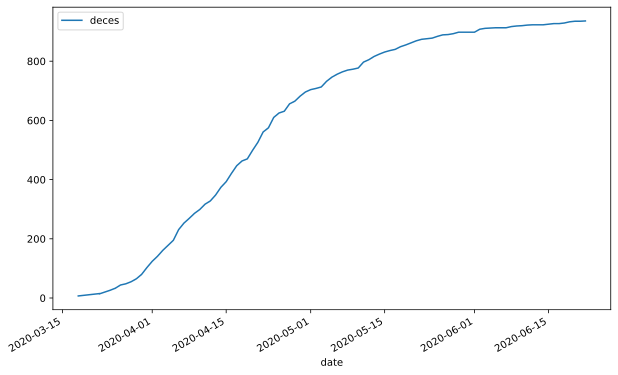

In [12]:
fig, ax = plt.subplots(figsize=figsize)
df_loc.plot(x='date', y='deces', ax=ax);

In [13]:
death = np.array(df_loc['deces'])
death


array([  7.,  nan,   7.,   9.,  nan,   9.,  11.,  nan,  11.,  13.,  nan,
        13.,  15.,  nan,  14.,  20.,  nan,  20.,  26.,  nan,  26.,  33.,
        nan,  33.,  44.,  44.,  48.,  55.,  65.,  80., 103., 124., 141.,
       161., 178., 195., 231., 253., 269., 286., 299., 317., 328., 348.,
       374., 393., 421., 447., 463., 470., 499., 526., 561., 575., 610.,
       625., 631., 656., 665., 682., 696., 704., 708., 713., 732., 746.,
       756., 764., 770., 773., 777., 797., 805., 816., 824., 831., 836.,
       840., 849., 855., 862., 869., 874., 876., 878., 884., 889., 890.,
       893., 898., 898., 898., 898., 908., 911., 912., 913., 913., 913.,
       917., 919., 920., 922., 923., 923., 923., 925., 927., 927., 929.,
       933., 935., 935., 936.])

In [14]:
for i, d, in enumerate(death):
    if np.isnan(d): death[i] = death[i-1]
        
death

array([  7.,   7.,   7.,   9.,   9.,   9.,  11.,  11.,  11.,  13.,  13.,
        13.,  15.,  15.,  14.,  20.,  20.,  20.,  26.,  26.,  26.,  33.,
        33.,  33.,  44.,  44.,  48.,  55.,  65.,  80., 103., 124., 141.,
       161., 178., 195., 231., 253., 269., 286., 299., 317., 328., 348.,
       374., 393., 421., 447., 463., 470., 499., 526., 561., 575., 610.,
       625., 631., 656., 665., 682., 696., 704., 708., 713., 732., 746.,
       756., 764., 770., 773., 777., 797., 805., 816., 824., 831., 836.,
       840., 849., 855., 862., 869., 874., 876., 878., 884., 889., 890.,
       893., 898., 898., 898., 898., 908., 911., 912., 913., 913., 913.,
       917., 919., 920., 922., 923., 923., 923., 925., 927., 927., 929.,
       933., 935., 935., 936.])

In [15]:
death.shape, np.diff(death).shape

((114,), (113,))

In [16]:
death[1:] = np.diff(death)
death[0] = 0

In [17]:
death

array([ 0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,
        0., -1.,  6.,  0.,  0.,  6.,  0.,  0.,  7.,  0.,  0., 11.,  0.,
        4.,  7., 10., 15., 23., 21., 17., 20., 17., 17., 36., 22., 16.,
       17., 13., 18., 11., 20., 26., 19., 28., 26., 16.,  7., 29., 27.,
       35., 14., 35., 15.,  6., 25.,  9., 17., 14.,  8.,  4.,  5., 19.,
       14., 10.,  8.,  6.,  3.,  4., 20.,  8., 11.,  8.,  7.,  5.,  4.,
        9.,  6.,  7.,  7.,  5.,  2.,  2.,  6.,  5.,  1.,  3.,  5.,  0.,
        0.,  0., 10.,  3.,  1.,  1.,  0.,  0.,  4.,  2.,  1.,  2.,  1.,
        0.,  0.,  2.,  2.,  0.,  2.,  4.,  2.,  0.,  1.])

In [18]:
df_loc['death'] = death
df_loc

,date,source,sourceType,nom,code,casConfirmes,hospitalises,deces,donneesRegionales,paysTouches,...,hospitalisesReadaptation,hospitalisesAuxUrgences,hospitalisesConventionnelle,reanimations,capaciteReanimation,decesEhpad,casEhpad,casConfirmesEhpad,casPossiblesEhpad,death
2204,2020-03-18,"{'nom': 'ARS Provence-Alpes-Côte d'Azur', 'url...",agences-regionales-sante,Provence-Alpes-Côte d'Azur,REG-93,566.0,178.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2205,2020-03-18,"{'nom': 'Santé publique France', 'url': 'https...",sante-publique-france,Provence-Alpes-Côte d'Azur,REG-93,574.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2206,2020-03-18,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Provence-Alpes-Côte d'Azur,REG-93,NaN,166.0,7.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2436,2020-03-19,"{'nom': 'ARS Provence-Alpes-Côte d'Azur', 'url...",agences-regionales-sante,Provence-Alpes-Côte d'Azur,REG-93,690.0,178.0,9.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
2437,2020-03-19,"{'nom': 'Santé publique France', 'url': 'https...",sante-publique-france,Provence-Alpes-Côte d'Azur,REG-93,693.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14400,2020-06-18,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Provence-Alpes-Côte d'Azur,REG-93,NaN,687.0,929.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
14521,2020-06-19,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Provence-Alpes-Côte d'Azur,REG-93,NaN,676.0,933.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0
14642,2020-06-20,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Provence-Alpes-Côte d'Azur,REG-93,NaN,657.0,935.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
14763,2020-06-21,{'nom': 'OpenCOVID19-fr'},opencovid19-fr,Provence-Alpes-Côte d'Azur,REG-93,NaN,656.0,935.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


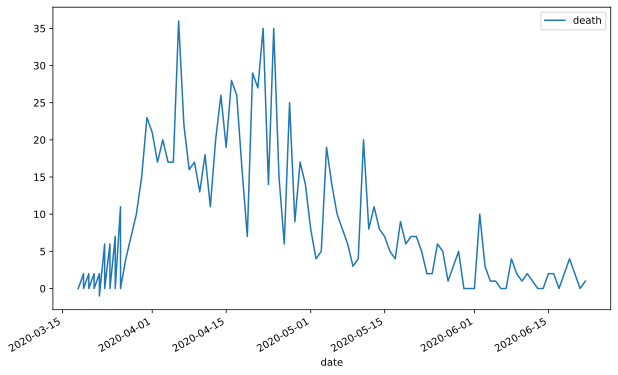

In [19]:
fig, ax = plt.subplots(figsize=figsize)
df_loc.plot(x='date', y='death', ax=ax);

In [20]:
X, y = df_loc['date'], df_loc['death']

In [21]:
X.shape, y.shape

((114,), (114,))

In [22]:
np.array(y)

array([ 0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,
        0., -1.,  6.,  0.,  0.,  6.,  0.,  0.,  7.,  0.,  0., 11.,  0.,
        4.,  7., 10., 15., 23., 21., 17., 20., 17., 17., 36., 22., 16.,
       17., 13., 18., 11., 20., 26., 19., 28., 26., 16.,  7., 29., 27.,
       35., 14., 35., 15.,  6., 25.,  9., 17., 14.,  8.,  4.,  5., 19.,
       14., 10.,  8.,  6.,  3.,  4., 20.,  8., 11.,  8.,  7.,  5.,  4.,
        9.,  6.,  7.,  7.,  5.,  2.,  2.,  6.,  5.,  1.,  3.,  5.,  0.,
        0.,  0., 10.,  3.,  1.,  1.,  0.,  0.,  4.,  2.,  1.,  2.,  1.,
        0.,  0.,  2.,  2.,  0.,  2.,  4.,  2.,  0.,  1.])

In [23]:
X = X.astype(int)
X = np.array(X)
X

array([1584489600000000000, 1584489600000000000, 1584489600000000000,
       1584576000000000000, 1584576000000000000, 1584576000000000000,
       1584662400000000000, 1584662400000000000, 1584662400000000000,
       1584748800000000000, 1584748800000000000, 1584748800000000000,
       1584835200000000000, 1584835200000000000, 1584835200000000000,
       1584921600000000000, 1584921600000000000, 1584921600000000000,
       1585008000000000000, 1585008000000000000, 1585008000000000000,
       1585094400000000000, 1585094400000000000, 1585094400000000000,
       1585180800000000000, 1585180800000000000, 1585267200000000000,
       1585353600000000000, 1585440000000000000, 1585526400000000000,
       1585612800000000000, 1585699200000000000, 1585785600000000000,
       1585872000000000000, 1585958400000000000, 1586044800000000000,
       1586131200000000000, 1586217600000000000, 1586304000000000000,
       1586390400000000000, 1586476800000000000, 1586563200000000000,
       1586649600000

In [24]:
X = (X-X[0])//86400000000000

In [25]:
np.array(X)
X

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  6,  6,  7,  7,  7,  8,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96])

In [26]:
y = np.array(y)
y

array([ 0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,
        0., -1.,  6.,  0.,  0.,  6.,  0.,  0.,  7.,  0.,  0., 11.,  0.,
        4.,  7., 10., 15., 23., 21., 17., 20., 17., 17., 36., 22., 16.,
       17., 13., 18., 11., 20., 26., 19., 28., 26., 16.,  7., 29., 27.,
       35., 14., 35., 15.,  6., 25.,  9., 17., 14.,  8.,  4.,  5., 19.,
       14., 10.,  8.,  6.,  3.,  4., 20.,  8., 11.,  8.,  7.,  5.,  4.,
        9.,  6.,  7.,  7.,  5.,  2.,  2.,  6.,  5.,  1.,  3.,  5.,  0.,
        0.,  0., 10.,  3.,  1.,  1.,  0.,  0.,  4.,  2.,  1.,  2.,  1.,
        0.,  0.,  2.,  2.,  0.,  2.,  4.,  2.,  0.,  1.])

In [27]:
def ig(x, tau, amp, mu, sigma) :
    return (x > tau) * amp * np.sqrt(1 / (2 * np.pi * (x-tau) ** 3)) * np.exp(-sigma * ((x-tau) - mu) ** 2 / (2 * mu ** 2 * (x-tau)))

https://lmfit.github.io/lmfit-py/model.html

In [28]:
model.fit?

Object `model.fit` not found.


The goal here is to compare methods which fit data with psychometric curves using logistic regression. Indeed, after (long) experiments where for instance you collected sequences of keypresses, it is important to infer at best the parameters of the underlying processes: was the observer biased, or more precise? 

While I was *forevever* using [sklearn](https://scikit-learn.org/stable/index.html) or [lmfit](https://lmfit.github.io/lmfit-py/) (that is, scipy's [minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)) and praised these beautifully crafted methods, I sometimes lacked some flexibility in the definition of the model. This notebook was done in collaboration with [Jenna Fradin](https://github.com/jennafradin), master student in the lab.

> tl; dr = Do not trust the coefficients extracted by a fit without validating for *methodological* biases.

One part of flexibility I missed is taking care of the *lapse rate*, that is the frequency with which you just *miss the key*. In a psychology experiment, you often see a fast sequence of trials for which you have to make a perceptual deccision, for instance press the Left or Right arrows. Sometimes you know the answer you should have done, but press the wrong eror. This error of distraction is always low (in the order of 5% to 10%) but could potentially change the results of the experiments. This is one of the aspects we will evaluate here.

In this notebook, I define a fitting method using [pytorch](https://pytorch.org/) which fits in a few lines of code :

by

$$
f ( x ; \mu , \lambda ) = \sqrt {\frac {\lambda }{2\pi x^3}} 
\exp (-\frac {\lambda (x-\mu )^{2}}{2\mu ^{2}x} )
$$

for 
https://en.wikipedia.org/wiki/Inverse_Gaussian_distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.invgauss.html

In [29]:
def ig(x, tau, amp, mu, sigma) :
    return (x > tau) * amp * np.sqrt(1 / (2 * np.pi * (x-tau) ** 3)) * np.exp(-sigma * ((x-tau) - mu) ** 2 / (2 * mu ** 2 * (x-tau)))

In [30]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.set_default_tensor_type("torch.DoubleTensor")
criterion = torch.nn.BCELoss(reduction="sum")
criterion = torch.nn.PoissonNLLLoss(reduction="sum")
criterion = torch.nn.MSELoss(reduction="sum")


class CovidRegressionModel(torch.nn.Module):
    def __init__(self, mu=14, tau=5, 
                 log_amp=torch.log(25*torch.ones(1)),
                 log_lambda=torch.log(4*torch.ones(1)),
                ):
        super(CovidRegressionModel, self).__init__()
        self.tau = torch.nn.Parameter(tau * torch.ones(1))
        self.mu = torch.nn.Parameter(mu * torch.ones(1))
        self.log_amp = torch.nn.Parameter(log_amp * torch.ones(1))
        self.log_lambda = torch.nn.Parameter(log_lambda * torch.ones(1))

    def forward(self, x):
        out = (x > self.tau) * torch.exp(self.log_amp)
        date = (x-self.tau)
        date[x<=self.tau] = 1
        out *= torch.sqrt(torch.exp(self.log_lambda) / (2 * np.pi * date ** 3)) 
        out *= torch.exp(-torch.exp(self.log_lambda) * (date - self.mu) ** 2 / (2 * self.mu ** 2 * date))
        out[x<=self.tau] = 0
        return out

learning_rate = 0.005
beta1, beta2 = 0.9, 0.999
betas = (beta1, beta2)
num_epochs = 2 ** 9 + 1
batch_size = 16
amsgrad = False # gives similar results
amsgrad = True  # gives similar results

def fit_data(
    X,
    y,
    learning_rate=learning_rate,
    batch_size=batch_size,  # gamma=gamma,
    num_epochs=num_epochs,
    betas=betas,
    verbose=False, **kwargs
):

    variables, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None])
    loader = DataLoader(
        TensorDataset(variables, labels), batch_size=batch_size, shuffle=True
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    covid_model = CovidRegressionModel()
    covid_model = covid_model.to(device)
    covid_model.train()
    optimizer = torch.optim.Adam(
        covid_model.parameters(), lr=learning_rate, betas=betas, amsgrad=amsgrad
    )
    for epoch in range(int(num_epochs)):
        covid_model.train()
        losses = []
        for variables_, labels_ in loader:
            variables_, labels_ = variables_.to(device), labels_.to(device)
            outputs = covid_model(variables_)
            loss = criterion(outputs, labels_)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            losses.append(loss.item())

        if verbose and (epoch % (num_epochs // 32) == 0):
            print(f"Iteration: {epoch} - Loss: {np.sum(losses)/len(variables):.5f}")

    covid_model.eval()
    variables, labels = torch.Tensor(X[:, None]), torch.Tensor(y[:, None])
    outputs = covid_model(variables)
    loss = criterion(outputs, labels).item() / len(variables)
    return covid_model, loss

In [31]:
X, y

(array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
         5,  6,  6,  6,  7,  7,  7,  8,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
        85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96]),
 array([ 0.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,  0.,  0.,  2.,
         0., -1.,  6.,  0.,  0.,  6.,  0.,  0.,  7.,  0.,  0., 11.,  0.,
         4.,  7., 10., 15., 23., 21., 17., 20., 17., 17., 36., 22., 16.,
        17., 13., 18., 11., 20., 26., 19., 28., 26., 16.,  7., 29., 27.,
        35., 14., 35., 15.,  6., 25.,  9., 17., 14.,  8.,  4.,  5., 19.,
        14., 10.,  8.,  6.,  3.,  4., 20.,  8., 11.,  8.,  7.,  5.,  4.,
         9.,  6.,  7.,  7.,  5.,  2.,  2.,  6., 

In [32]:
covid_model, loss = fit_data(X, y, verbose=True)
print("Final loss =", loss)

Iteration: 0 - Loss: 143.38224
Iteration: 16 - Loss: 138.38474
Iteration: 32 - Loss: 122.03905
Iteration: 48 - Loss: 80.57139
Iteration: 64 - Loss: 60.92357
Iteration: 80 - Loss: 56.48908
Iteration: 96 - Loss: 53.67658
Iteration: 112 - Loss: 51.57053
Iteration: 128 - Loss: 49.83477
Iteration: 144 - Loss: 48.39297
Iteration: 160 - Loss: 47.02814
Iteration: 176 - Loss: 45.82582
Iteration: 192 - Loss: 44.67064
Iteration: 208 - Loss: 43.67586
Iteration: 224 - Loss: 42.73046
Iteration: 240 - Loss: 41.81168
Iteration: 256 - Loss: 41.02677
Iteration: 272 - Loss: 40.22288
Iteration: 288 - Loss: 39.51327
Iteration: 304 - Loss: 38.83027
Iteration: 320 - Loss: 38.17742
Iteration: 336 - Loss: 37.59276
Iteration: 352 - Loss: 37.01748
Iteration: 368 - Loss: 36.51229
Iteration: 384 - Loss: 36.00039
Iteration: 400 - Loss: 35.58593
Iteration: 416 - Loss: 35.11838
Iteration: 432 - Loss: 34.69001
Iteration: 448 - Loss: 34.29356
Iteration: 464 - Loss: 33.89243
Iteration: 480 - Loss: 33.53753
Iteration: 49

In [44]:
covid_model.eval()
outputs = covid_model(torch.Tensor(X[:, None]))
y_pred = outputs.detach().numpy()

In [50]:
covid_model.mu.item()

28.32130110043607

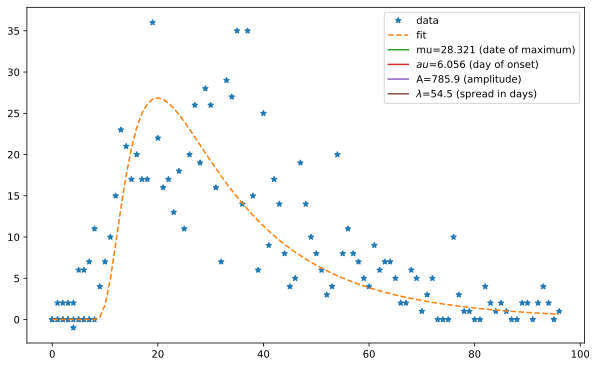

In [56]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(X, y, '*', label='data')
ax.plot(X, y_pred, '--', label='fit')
ax.plot([], [], label=f'mu={covid_model.mu.item():.3f} (date of maximum)')
ax.plot([], [], label=f'$\tau$={covid_model.tau.item():.3f} (day of onset)')
ax.plot([], [], label=f'A={torch.exp(covid_model.log_amp).item():.1f} (amplitude)')
ax.plot([], [], label=f'$\lambda$={torch.exp(covid_model.log_lambda).item():.1f} (spread in days)')
ax.legend();

## some book keeping for the notebook

In [34]:
%load_ext watermark
%watermark -i -h -m -v -p numpy,pandas,matplotlib,torch  -r -g -b

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2020-10-11T15:35:15+02:00

CPython 3.8.6
IPython 7.18.1

numpy 1.19.2
pandas 1.1.3
matplotlib 3.3.2
torch 1.5.1

compiler   : Clang 12.0.0 (clang-1200.0.32.2)
system     : Darwin
release    : 19.6.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit
host name  : ekla
Git hash   : fb47cf4ffb8d6d83acb1fb05b23c988988c782d1
Git repo   : https://github.com/laurentperrinet/sciblog.git
Git branch : master
